# Vector Autoregression Integrated Moving Average Model (VARIMA) 

In this section, we forecast EEG data using a VARIMA model. A VARIMA model extends the univariate ARIMA framework to multiple interdependent time series, making it well-suited for multichannel EEG signals, where activity from one electrode is highly correlated with another.

## Background

A VARIMA model is a multivariate extension of the univariate ARIMA framework. It is used to model and forecast systems where multiple time series influence one another, such as activity measured across multiple EEG channels. The model consists of three hyperparameters:

- **$q$**, the order of the moving-average (MA) component  
- **$p$**, the order of the vector autoregressive (VAR) component  
- **$d$**, the differencing order used to obtain stationarity  


Lets break down each of these components to understand how they capture the dynamics within a set of time series. First, define $y_t$ as a vector of EEG values across $m$ channels at time $t$ (i.e., $y_t \in \mathbb{R}^m$).

---

### Moving-Average (MA) Component

The vector MA component is crucial for understanding how brief, unobserved events, like a sudden cognitive shift or external stimulus, echo across different EEG channels over time. We model this echo using "shocks" or "innovations" that propogate through the system.

#### Defining the model
The vector MA model delineates that $y_t$ is a weighted linear combination of the current shock ($\epsilon_t$) and the past $q$ shocks. In simpler terms, the current EEG signal is predicted by the summation of the current and previous forecasting errors for the last $q$ timesteps. 

Here is the core equation:
$$
y_t = \mu + \epsilon_t + \sum_{k=1}^q \Theta_k \epsilon_{t-k} \tag{1}
$$

where:

- $\epsilon_t$: A vector representing the unpredictable, instantaneous shock occurring at time $t$. This is what drives the current change.
- $\Theta_k$ (echo matrix): An $m \times m$ matrix that captures how the shock from $k$ time steps ago ($\epsilon_{t-k}$) influences current activity. This matrix represents the spatial correlations in forecast error at timestep $k$.  
- $\mu$: is a vector containing the steady-state mean value for each EEG channel.

##### The Backshift Operator for Compact Notation

To make the equations cleaner, we use the Backshift Operator ($B$). This operator simply shifts a time series backward in time: $B^k x_t = x_{t-k}$.

We define the polynomial matrix $\Theta(B)$ that collects all of the echo matrices as:  

$$
\Theta(B) = \sum_{k=1}^q \Theta_k B^k
$$

Using this, the compact representation of the model takes the form of:

$$
y_t = \mu + (I + \Theta(B))\epsilon_t \tag{2}
$$

where $I$ is an identity matrix.


#### Model Mean and Autocovariance

To fully understand the vector MA process, we need its statistical properties, specifically its mean, variance, and autocovariance. These depend entirely on the properties of the shock vector, $\epsilon_t$.

##### Properties of the shock vector

The shocks are assumed to be a white noise process. They are independent and identically distributed (i.i.d.) and have no time structure:

$$
\begin{align*}
\epsilon &\overset{\text{iid}} \sim N(0, \Sigma) \\
E[\epsilon_t \epsilon_t^T] &= \Sigma \\
\text{Cov(}\epsilon_t, \epsilon_{t+k}\text{)} &= 0 \qquad \text{for } k \neq 0
\end{align*}
$$

Where $\Sigma$ is the covariance matrix of the shocks, telling us how large and related the instantaneous shocks are across the $m$ channels.

Given these properties, the expected value of an MA($q$) process is:

$$
\begin{align*}
E[y_t] &= \mu + (I + \Theta(B)) \epsilon_t\\
&= E[\mu + (I + \Theta(B) \epsilon_t)] \\
&= \mu + \sum_{k=0}^q \Theta_k E[\epsilon_{t-k}] \\
&= \mu
\end{align*}
$$

The variance, $\Gamma_y(0)$, tells us the total amount of variation in each EEG channel at any given time $t$. We derive this by summing the variance contributions of all independent shocks from $k=0$ to $q$. Setting $\Theta_0 = I$:

$$
\begin{align*}
\text{Var}(y_t) = \Gamma_y(0) &= \text{Var}(\mu + (I + \Theta(B)) \epsilon_t) \\
&= \text{Var}(\sum_{k=0}^q \Theta_k \epsilon_{t-k}) \\
&= \sum_{k=0}^q \Theta_k \text{Var}(\epsilon_{t-k}) \Theta_k^T \\
&= \sum_{k=0}^q \Theta_k \Sigma \Theta_k^T
\end{align*}
$$

Similarly the autocovariance, which indicates how the EEG signal at time $t$ is correlated with the EEG signal at a later time $t+l$ where $l$ is the lag, can be derived from:

$$
\begin{align*}
\Gamma_y(l) &= \text{Cov}(y_t, y_{t+l}) \\
&= E[(\mu + (I + \Theta(B)) \epsilon_t)(\mu + (I + \Theta(B)) \epsilon_{t+l})^T] \\
&= E[(\sum_{k=0}^q \Theta_i \epsilon_{t-k})(\sum_{j=0}^q \Theta_j \epsilon_{t+l-j})^T] \\
&= E[(\sum_{k=0}^q \Theta_i \epsilon_{t-k})(\sum_{j=0}^q \epsilon_{t+l-j}^T \Theta_j^T)] \\
&= \sum_{k=0}^q \sum_{j=0}^q \Theta_i E[\epsilon_{t-k} \epsilon_{t+l-j}^T] \Theta_j^T \\
&= \sum_{k=0}^{q-l} \Theta_i \Sigma \Theta_{k+l}^T \qquad \text{for } 0 \leq k \leq q
\end{align*}
$$

**Key Takeaway**: For any lag $l$ greater than $q$ (the look back window), the autocovariance $\Gamma_y(l)$ is zero. This is the defining feature of the vector MA model: the impact of the past shocks completely dies out after $q$ time steps.

---

### Autoregressive (VAR) Component

The VAR component models the most intuitive aspect of time series analysis: how the past activity of all EEG channels influences their present activity. Specifically, a VAR($p$) model looks back over $p$ time steps to predict the current EEG vector, $y_t$.

#### Defining the VAR model
Here is the core equation of a VAR($p$) process:
$$
y_t = \delta + \sum_{j=1}^p \Phi_j y_{t-j} + \epsilon_t \tag{3}
$$

where 
- $\Phi_j$ (Influence matrix): An $m \times m$ matrix of coefficients that reflects the influence of the EEG signal at time $t-j$ on every channel at the current time $t$. This is where the cross-channel dependence is captured.
- $\delta$ (Intercept): A constant vector ensuring the series fluctuates around its long-term mean.


#### Compact notation and the Mean-Adjusted intercept

Just as with the MA model, we can simplify the structure using the backshift operator $B$ and by defining the polynomial autoregressive operator $\Phi(B)$:

$$
\Phi(B) = \sum_{j=1}^p \Phi_j B^j
$$

This allows enables Equation (3) to be written in a more compact form: 

$$
(I - \Phi(B))\, y_t = \delta + \epsilon_t \tag{4}
$$

Out of convention, the autoregressive operator is typically placed on the left hand side to clarify the structure of the model and indicate that it acts on the observed value $y_t$.

Note, the intercept term $\delta$ does not the represent the means of each time series, but rather is related to it. By taking the expected value of Equation (3) and assuming the process is stationary (i.e., $E[y_t] = E[y_{t-j}] = \mu$), we can express $\delta$ in terms of $\mu$:

$$
E[y_t] = E[\delta + \Phi(B)y_t + \epsilon_t]\\
E[y_t] = E[\delta] + E[\Phi(B)y_t] + E[\epsilon_t] \\
\mu = \delta + \Phi(B)\mu \\
\delta = \mu - \Phi(B)\mu  \\
\delta = (I - \Phi(B)) \mu \\
$$

#### Model Mean and Autocovariance

Assuming the process is stationary, the expected value of the Var($p$) process is a constant vector $\mu$. As seen above, the mean is a direct function of the intercept $\delta$ and the autoregressive coefficients $\Phi_j$.

$$
\begin{align*}
E[y_t] = \mu &= E[\delta + \Phi(B)y_t + \epsilon_t] \\
&= \delta + E[\sum_{j=1}^p \Phi_j y_{t-j}] \\
&= \delta + \sum_{j=1}^p \Phi_j E[y_{t-j}] \\
&= \delta + \sum_{j=1}^p \Phi_j \mu \\
\mu &= \delta(I-\sum_{j=1}^p \Phi_j)^{-1}
\end{align*}
$$

The variance, $\Gamma_y(0)$, of this process is given by:

$$
\begin{align*}
\text{Var}(y_t) = \Gamma_y(0) &= \text{Var}(\delta + \Phi(B)y_t + \epsilon_t) \\
&= \sum_{j=1}^{p} \text{Var} (\Phi_j y_{t-j}) + \text{Var}(\epsilon_t) \\
&= \sum_{j=1}^{p} \Phi_j \text{Var}(y_{t-j}) \Phi_j^T + \Sigma \\
&= \sum_{j=1}^{p} \Phi_j \Gamma_y(0) \Phi_j^T + \Sigma \\
\Gamma_y(0) &= \Sigma(I-\sum_{j=1}^{p} \Phi_j \Phi_j^T)^{-1}
\end{align*}
$$

Note, unlike the vector MA($q$) model where the autocovariance cuts off sharply, the VAR($p$) model has an autocovariance function that decays exponentially. This reflects the fact that the influence of a signal's past never truly vanishes, it only fades over time.

---

### The VARMA Model

While the VAR model captures the influence of past signals and the vector MA model captures the influence of past shocks, neither alone may be sufficient for highly complex data like multichannel EEG. Whatsmore, is that fitting each model independently to a complex time series may require higher order terms, which can be difficult to fit. However, when combined together, they form a more powerful VARMA model. By combining Equations (2) and (4), we arrive at the representation:

$$
(I - \Phi(B))\, y_t = \delta + (I + \Theta(B)) \epsilon_t \tag{5}
$$


### Extending to VARIMA

#### Differencing Operator

A critical challenge in analyzing physiological data like EEG is that the time series is often non-stationary. This means its statistical properties (like the mean and variance) change over time, which violates the core assumptions of the standard VARMA model. To overcome this, we use a technique called differencing before fitting the model. This technique involves taking the consecutive difference between current and past time points from one another to stabilize the mean of the series. Applying $d$ levels of differencing creates a new, stationary series, $w_t$:

$$
w_t = (1 - B)^d y_t \tag{6}
$$

where $d=1$ (first order differencing) means $w_t = y_t - y_{t-1}$.

#### Defining the VARIMA Model
Substituting this into the VARMA form yields the full VARIMA($p$, $d$, $q$) model:

$$
\underbrace{(I - \Phi(B))}_{\text{VAR($p$)}}\underbrace{(1 - B)^d}_{\text{Differencing Operator}} y_t = \delta + \underbrace{(I + \Theta(B))}_{\text{MA($q$)}} \epsilon_t \tag{7}
$$



This formulation allows the VARIMA model to capture both temporal dynamics, which describe how the EEG signal evolves over time, and spatial interactions, which describe how activity flows across channels. As a result, it is well suited for forecasting complex, multichannel physiological data.

### Model Assumptions

Like any advanced statistical framework, the VARIMA model relies on several fundamental assumptions. These principles are essential because they ensure the model is both mathematically sound (stable) and yields reliable, interpretable forecasts.

1. **Linearity**: The influence of past values ($y_{t-j}$) and past shocks ($\epsilon_{t-k}$) on the current signal ($y_t$) is assumed to be a simple weighted sum Equation (7). The parameter matrices $\Phi_j$ and $\Theta_k$ act purely as linear scaling factors.
   -  Why it's necessary: Linearity allows for closed-form solutions for properties like the mean and variance, making the model computationally tractable and easier to analyze.
   -  Contextual Implication (EEG): If the true interactions between brain regions are highly non-linear (e.g., if one region's influence only turns on after a specific threshold is reached), the VARIMA model will only capture a first-order approximation of the true dynamics.

2. **Stationarity**: After applying $d$ levels of differencing to the observed time series $y_t$ Equation (6), the resulting series $w_t = (I - B)^d y_t$ must be stationary.
   -  Why it's necessary: If the series is non-stationary, statistical estimation techniques fail because parameters estimated from one segment of the data are not guaranteed to be valid for another segment.
   -  Contextual Implication (EEG): EEG data often contains slow drifts or trends, making it non-stationary. The integration factor ($d$) in VARIMA is specifically used to stabilize the mean and covariance structure before the VARMA modeling begins.

3. **White Noise Innovations**: The innovations $\epsilon_t$ must be a white noise process with no autocorrelation (i.e., $\text{Cov(}\epsilon_t, \epsilon_{t+k}\text{)}=0$) and constant covariance.
       -  Important Caveat: While there is no autocorrelation over time, the model does allow for instantaneous correlations across channels (off-diagonal elements in $\Sigma$ are non-zero). This is essential for multichannel data where several signals are shocked simultaneously by a common event.
   -  Why it's necessary: If the innovations are correlated over time, it implies that there is unexplained systematic structure left in the residuals, meaning the model is incomplete and its predictions are sub-optimal.

4. **Stability (Causality) and Invertibility**: The roots of the characteristic equation associated with the autoregressive operator $(I - \Phi(B))$ and moving-average operator $(I + \Theta(B))$ must lie outside the unit circle. This ensures the process is causal, meaning the current value $y_t$ can be expressed as a converging linear combination of current and past shocks
   -  Why it's necessary: These conditions mathematically ensure two things. First, that the influence of a random shock fades to zero over time (preventing unstable, exploding forecasts). Second, that the model has a unique and identifiable representation, which is crucial for reliable parameter estimation.

## Implementing VARIMA

Now that we have covered the principles and assumptions of the VARIMA model, lets see it in action. We are going to use the `VARMAX` class from the statsmodels package, which enables us to estimate a VAR, VMA, or VARMA model. The dataset we will be forecasting is EEG activity from an SSVEP study (Gu et al., 2014).

In [1]:
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.api import VARMAX, VAR
from statsmodels.tsa.stattools import adfuller, acf, pacf, ccf
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from tqdm import trange
import matplotlib.pyplot as plt
import pandas as pd
import itertools
from joblib import Parallel, delayed

%matplotlib inline

In [2]:
# load single subject from Gu et al., 2024 SSVEP experiment
# Note, data has been downsampled to 250 Hz
data = np.load('../Data/Gu_et_al_2024_SSVEP_dataset/Data/data_s1_64_down.npy')

In [3]:
# block x stimulation frequency x time x channels x conditions (i.e., modulation depths; low and high luminance ratios)
# stimulation frequencies are from 1-60 in increments of 1 Hz
nBlocks, nFreqs, nTime, nChans, nCons = data.shape

# extract a single set of time series for 4 Hz stimulation
# transpose to make channels x time
trial_idx = 10
stim_idx = 3
X = data[trial_idx, stim_idx, :, :, 1].T

# SSVEPs are typically localized over the P-PO-O electrodes 
ssvep_chan_names = ['Pz', 'PO5', 'PO3', 'POz', 'PO4', 'PO6', 'O1', 'Oz', 'O2']
ssvep_chans_idx = [48,54,55,56,57,58,61,62,63]

ssvep_chans_dict = dict(zip(ssvep_chan_names, ssvep_chans_idx))

In [4]:
# construct time vector. Stimulation time is 5s, and epochs included 0.14s post stimulus offset
Fs = 250.
t = np.arange(0, 5.14, 1/Fs) * 1000

Lets visualize the data to get a sense of any structures that might be present

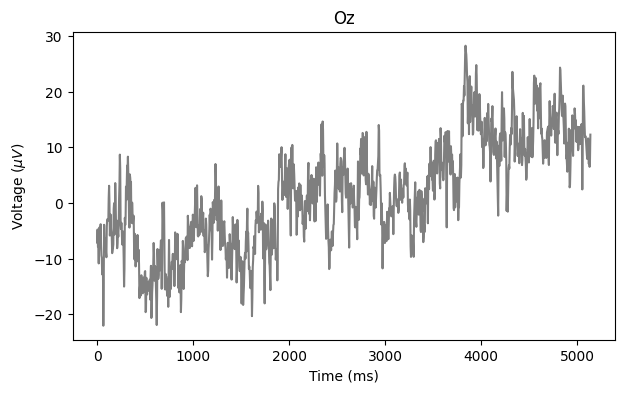

In [5]:
plt.figure(figsize=(7,4))
plt.plot(t, X[ssvep_chans_dict['Oz'], :], color='k', alpha=0.5)
plt.xlabel('Time (ms)')
plt.ylabel(r'Voltage ($\mu V$)')
plt.title('Oz')
plt.show()

We can clearly see that the data is non-stationary and includes a linear trend. Lets see at how the time series looks after applying a differencing transformation and performing a test for non-stationarity

In [6]:
# define function for computing the n-th order difference
def nth_order_difference(X, n=1, axis=0):
    for _ in range(n):
        X = np.diff(X, axis=axis)
    return X

In [7]:
d = 1
X_diff = nth_order_difference(X, n=d, axis=-1)

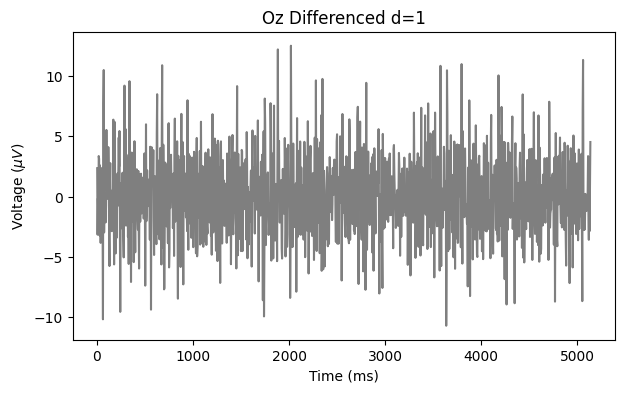

In [8]:
plt.figure(figsize=(7,4))
plt.plot(t[d:], X_diff[ssvep_chans_dict['Oz'], :], color='k', alpha=0.5)
plt.xlabel('Time (ms)')
plt.ylabel(r'Voltage ($\mu V$)')
plt.title(f'Oz Differenced d={d}')
plt.show()

A common approach for testing if a multivariate time series is non-stationary is to apply the Augmented Dickey-Fuller (ADF) test to each variable individually, so we will just check stationarity at the electrode visualized above for brevity. If the results of the ADF test fail to reject the null hypothesis, then the time series is non-stationary.

In [9]:
adf_test = adfuller(X_diff[ssvep_chans_dict['Oz'], :], autolag='AIC')
print(f'p-value = {adf_test[1]:0.2e}')
print('Failed to reject null, time series is non-stationary') if adf_test[1] > 0.05 else print('Rejected null, time series is stationary')

p-value = 1.65e-19
Rejected null, time series is stationary


The results of the differencing transform have yielded a non-stationary time series. Now lets look at the autocorrelation and partial autocorrelation plots to get a sense of what the order of the model might be. Since we are dealing with multivariate data, we will have to compute the cross correlation for all possible pairs of time series. Instead of visualizing the correlation at each lag for each pair, we will instead look at the first lag to have a significant correlation to get a rough idea of the spatial relationships:

In [10]:
def get_first_significant_lag(series1, series2, max_lags=20, is_pacf=False):
    n_obs = len(series1)
    conf_level = 1.96 / np.sqrt(n_obs)
    
    # Determine which function to use
    if series1 is series2:
        values = pacf(series1, nlags=max_lags) if is_pacf else acf(series1, nlags=max_lags)
    else:
        # Cross-correlation
        values = ccf(series1, series2)[:max_lags+1]

    # Find first lag (starting from 1 to ignore lag 0 correlation) where abs > CI
    for lag, val in enumerate(values[1:], start=1):
        if abs(val) > conf_level:
            return lag
    return 0 # No significant lag found

In [11]:
lag_acf_mat = np.zeros((nChans, nChans))
lag_pacf_mat = np.zeros((nChans, nChans))
for i in range(nChans):
    for j in range(nChans):
        lag_acf_mat[i, j] = get_first_significant_lag(X_diff[i, :], X_diff[j,:], 100)
        lag_pacf_mat[i, j] = get_first_significant_lag(X_diff[i, :], X_diff[j,:], 100, is_pacf=True)

In [12]:
# focus on off diagonals to get ccf
unique_ccf_lags, ccf_lag_freqs = np.unique((lag_acf_mat-np.diag(lag_acf_mat)).ravel(), return_counts=True)

In [13]:
# zero out lag 0 since we masked it
ccf_lag_freqs[unique_ccf_lags == 0] = 0

C:\Users\Garrett\AppData\Local\Temp\ipykernel_11672\2332414478.py:2: RuntimeWarning: divide by zero encountered in log
  ax.bar(unique_ccf_lags, np.log(ccf_lag_freqs), color='lightblue')
d:\EEG_Forecast\.venv\Lib\site-packages\matplotlib\transforms.py:2437: RuntimeWarning: invalid value encountered in dot
  return Affine2D(np.dot(self._b.get_affine().get_matrix(),


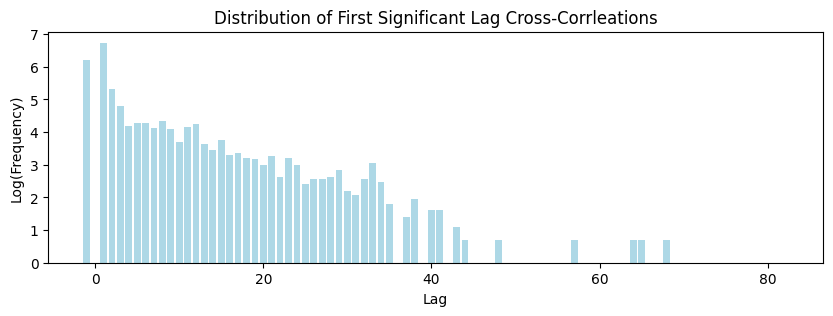

In [14]:
fig, ax = plt.subplots(nrows=1, figsize=(10, 3), sharex=True, sharey=True)
ax.bar(unique_ccf_lags, np.log(ccf_lag_freqs), color='lightblue')
ax.set_ylabel('Log(Frequency)')
ax.set_xlabel('Lag')

ax.set_title('Distribution of First Significant Lag Cross-Corrleations')

plt.show()

In [15]:
print(f'Electrode ACFs: {(np.diag(lag_acf_mat))}\n')
print(f'Electrode PACFs: {np.diag(lag_acf_mat)}')

Electrode ACFs: [1. 2. 2. 1. 1. 2. 1. 2. 1. 1. 2. 1. 1. 1. 2. 2. 1. 1. 1. 1. 1. 2. 2. 1.
 1. 1. 1. 1. 1. 1. 2. 2. 2. 2. 2. 2. 2. 1. 1. 1. 2. 2. 2. 1. 1. 2. 2. 1.
 1. 1. 2. 1. 1. 1. 1. 2. 2. 2. 2. 1. 1. 1. 2. 2.]

Electrode PACFs: [1. 2. 2. 1. 1. 2. 1. 2. 1. 1. 2. 1. 1. 1. 2. 2. 1. 1. 1. 1. 1. 2. 2. 1.
 1. 1. 1. 1. 1. 1. 2. 2. 2. 2. 2. 2. 2. 1. 1. 1. 2. 2. 2. 1. 1. 2. 2. 1.
 1. 1. 2. 1. 1. 1. 1. 2. 2. 2. 2. 1. 1. 1. 2. 2.]


When looking at the distribution of the first lags with a signficant cross-correlation, we see that a lag of 1 ($y_t$ vs $y_{t+1}$) has the highest frequency. This is not suprising, considering that electrical activity is conducted across the scalp extremely quickly, hence the poor spatial resolution of EEG. Looking at the ACFs and PACFs along the diagonal, we see a similar result of 1-2 lags. 

A more refined approach is to use information criterion metrics, such as AIC and BIC, and perform a grid search over a range of $p$ and $q$ values to find an optimal model that balances parsimony and minimizing residuals. However, before we start fitting models we need to first address the issue of multicolinearity, which is prevalent in brain data. We will mitigate this by performing PCA to extract uncorrelated components. To reduce computational load when fitting the model, lets split it into a train and test set.

In [ ]:
# NOTE: VARIMA and PCA need data in shape n observations x k_features
X_train, X_test = X_diff[:, :500], X_diff[:, 500:]

X_train = X_train.T
X_test = X_test.T

In [76]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

pca = PCA(n_components=10) # keep small to decrease computation time
X_pca = pca.fit_transform(X_scaled)

In [18]:
# Create helper function to parallelize fitting a VARMAX model
def evaluate_VARMAX(order, data, maxiter=10, verbose=False):
    try: 
        model = VARMAX(data, order=order, trend='c')
        results = model.fit(maxiter=maxiter, disp=verbose)
        return results.bic
    except:
        return float('inf')

In [26]:
q_range = np.arange(0, 5) # MA terms
p_range = np.arange(1, 5) # AR terms

pdq = list(itertools.product(p_range, q_range))

# Parallel processing
max_iter = 500
info_criteria = Parallel(n_jobs=6)(delayed(evaluate_VARMAX)(order, X_pca, max_iter) for order in pdq)
    

In [ ]:
varima_fit_summary = pd.DataFrame({
    'p': [x[0] for x in pdq],
    'q': [x[1] for x in pdq ],
    'bic': info_criteria
})

print(varima_fit_summary.sort_values(by='bic').reset_index(drop=True))

    p  q           bic
0   1  2  19298.353206
1   2  1  19402.889708
2   2  2  19643.223545
3   4  1  19836.689927
4   3  2  20020.131633
5   3  1  20078.285769
6   1  1  20146.195842
7   4  2  20186.258637
8   2  0  20429.207709
9   1  3  20448.200676
10  4  0  20604.512966
11  2  3  20736.182413
12  3  0  20818.359101
13  2  4  20886.926103
14  4  3  20991.460319
15  3  3  21101.565392
16  1  0  21110.983934
17  1  4  21259.271450
18  3  4  21464.355314
19  4  4  21698.212322


Looking at the results of our grid search, we see that an VARIMA model with an order of $p=1$, $q=2$, $d=1$ (since we only used a 1st order difference), yields the lowest BIC score. Note, often times you may encounter convergence or estimation warnings when trying to fit each model. Although the VARIMA model is superior to a single VAR or MA model in theory, in practice it is very difficult to estimate a stable model given that the MA component requires maximum likehood estimation. It can also be challenging to identify a single unique model that captures the dynamics within your data, since different combinations of hyperparameters can produce the same quality of fit. Furthermore, VARIMA models can take quite a bit of time to fit, hence our use of parallel processing to explore the parameter space.

In practice, the VAR model is much easier to estimate using ordinary least-squares. Whatsmore, a VARIMA model can be approximated by a VAR model as the latter increases in parameter count. This is because a VAR model is equivalent to an MA model with an infinite number of parameters, and vice versa. Let use the statsmodels function `VAR`, which has a built-in method for selecting the best model based on information scores:

In [88]:
pca2 = PCA(n_components=nChans) # increase number of components since VAR model is easier to fit
X_pca2 = pca2.fit_transform(X_scaled)
var_model = VAR(X_pca2)

In [53]:
# select the optimal model based information criterion
lag_comparison = var_model.select_order(maxlags=6, trend='c')
print(lag_comparison.summary())
print(f'Best BIC lag: {lag_comparison.bic}')

 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0      -78.30     -77.76*   9.855e-35      -78.09
1      -81.62      -46.23   3.954e-36      -67.72
2      -93.79      -23.56   4.075e-41      -66.22
3      -100.2       4.900   5.142e-43      -58.93
4      -119.3       20.59   2.047e-49      -64.40
5      -150.7       24.09   3.287e-59      -82.07
6     -238.0*      -28.37  2.184e-89*     -155.7*
-------------------------------------------------
Best BIC lag: 0


In our previous VARMAX analysis, we were forced to limit our scope to a subset of PCA components due to the heavy computational tax of the Moving Average (MA) terms. However, by transitioning to a pure Vector Autoregression (VAR) approach, we gain significant efficiency. This allows us to fit the model to the full suite of PCA components, capturing a more holistic snapshot of the brain's electrical activity. 

Looking at the grid search results, it is apparent that the best model according to BIC is an VAR(0). In other words, a model with a constant term for the intercept. In contrast, AIC, FPE, and HQIC all suggest that an VAR(6) fit the time series the best. Lets compare the forecasting power of the VARMA(1, 2) and VAR(6) models to determine which is the top performer. We'll ignore the VAR(0) model since it just uses the average of the time series to generate forecasts, which is common to use in baseline comparisons to assess if the added complexity by a VAR model is justified.

## Forecasting

In [66]:
# Fit VARMAX 
varma_model = VARMAX(X_pca, order=(1, 2))
varma_results = varma_model.fit(maxiter=500)

d:\EEG_Forecast\.venv\Lib\site-packages\statsmodels\tsa\statespace\varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
d:\EEG_Forecast\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [68]:
# Fit VAR(6)
var_6_model = VAR(X_pca2)
var_6_results = var_6_model.fit(6, trend="c")

In [ ]:
# Set the forecasting horizon
horizon = 764

In [152]:
varma_forecasts = varma_results.forecast(steps=horizon)

#Project back into original space
varma_forecasts_projected = pca.inverse_transform(varma_forecasts).T

In [153]:
var_6_forecasts = var_6_results.forecast(X_pca2, steps=horizon)
var_6_forecasts_projected = pca2.inverse_transform(var_6_forecasts).T

In [ ]:
# scale test data for plotting comparison
X_test_scaled = scaler.transform(X_test).T

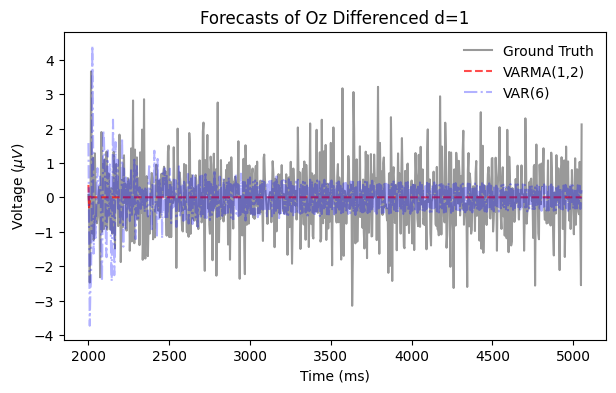

In [155]:
plt.figure(figsize=(7,4))
plt.plot(t[500:500+horizon], X_test_scaled[ssvep_chans_dict['Oz'], :horizon], color='k', label='Ground Truth', alpha=0.4)
plt.plot(t[500:500+horizon], varma_forecasts_projected[ssvep_chans_dict['Oz'], :], color='r', label='VARMA(1,2)', linestyle='--', alpha=0.7)
plt.plot(t[500:500+horizon], var_6_forecasts_projected[ssvep_chans_dict['Oz'], :], color='b', label='VAR(6)', linestyle='-.', alpha=0.3)
plt.xlabel('Time (ms)')
plt.ylabel(r'Voltage ($\mu V$)')
plt.legend(frameon=False)
plt.title(f'Forecasts of Oz Differenced d={d}')
plt.show()

In [158]:
varma_mae = abs(X_test_scaled[:, :horizon] - varma_forecasts_projected).mean()
var_6_mae = abs(X_test_scaled[:, :horizon] - var_6_forecasts_projected).mean()

print('Forecast MAE')
for model, metric in zip(['VARMA(1, 2)', 'VAR(6)'], [varma_mae, var_6_mae]):
    print(f'{model}: {metric:0.3f}')

Forecast MAE
VARMA(1, 2): 0.781
VAR(6): 0.903


Qualitative inspection of the forecasts suggest that the VAR(6) is superior to the VARMA(1,2), since the former closesly matches ampltiude deflections earlier in the forecasting period while the latter predicts a constant value throughout. However, comparison of their mean absolute error (MAE) reveals that the VARMA(1,2) actually yields smaller forecasting error. Ultimately, we see that both methods struggle to generate long-term forecasts of EEG activity. This is because they assume that the relationship between time points is strictly linear, but it is well known that neural activity evolves in a non-linear fashion. Its likely that these models are only useful if the training data is constrained to a small window of activity (e.g., 25 ms) and they are used generate short-horizon forecasts (e.g., 1-3 future points).

# Summary


VARIMA is a standard time-series analysis algorithm that combines the utility of VAR and MA models to decrease the number of parameters used to capture spatiotemporal dynamics and generate forecasts. In practice, though, estimating the VARIMA model is challegenging, and it is more practical to construct a VAR model that can approximate its fit. Within the context of forecasting EEG activity, both of these models suffer at generating long-term forecasts since they are unable to capture important non-linear dynamics.